Open the Github notebook that you want to work with in Google Colab. Change the domain from '**github.com**' to '**githubtocolab.com**'. The notebook will open in Colab.

# Libraries

In [ ]:
!pip install Sastrawi
!pip install clean-text
!pip install deep-translator

In [ ]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary
from cleantext import clean
from collections import Counter

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
import sklearn

In [ ]:
# !pip freeze > requirements.txt

# Get Data from ES and prepare DF

In [ ]:
import requests
import json

In [ ]:
elasticsearch_url = 'https://es-1.datanusantara.com:9201'
username = 'adminkibana'
password = 'kibanaPASS!@#2019'
index_endpoint = 'news-crawl-production-v2'

In [ ]:
#query = {
#    "_source": ["text", "source","source_detail","target"],
 #   "size":600,
  #  "query": {
   #     "match": {
    #              "source": "news"
     #           },
      #  "match": {
       #     "target": "banggai"
  #      }
 #   }
#}

#search_url = f"{elasticsearch_url}/{index_endpoint}/_search"
#response = requests.get(search_url, json=query, auth=(username, password))

In [ ]:
query = {
  "_source": ["target", "title","description_content"],
  "size": 1000,
  "query": {
    "bool": {
      "must": [],
      "filter": [
        {
          "match_all": {}
        },
        {
          "bool": {
            "should": [


              {
                "match_phrase": {
                  "target": "banggai"
                }
              }
            ],
            "minimum_should_match": 1


          }
        }
      ]
    }
  }
}
search_url = f"{elasticsearch_url}/{index_endpoint}/_search"
response = requests.get(search_url, json=query, auth=(username, password))

In [ ]:
search_url


'https://es-1.datanusantara.com:9201/news-crawl-production-v2/_search'

In [ ]:
search_results = response.json()
# print(json.dumps(search_results, indent=2))
print(len(search_results['hits']['hits']))

1000


In [ ]:
# Parse the response to extract relevant data
search_results = response.json()

# Process the data and create a DataFrame
data = []
for hit in search_results.get("hits", {}).get("hits", []):
    target = hit["_source"]["target"]
    title = hit["_source"]["title"]
    text = hit["_source"]["description_content"]

    data.append({"target": target,  "title": title, "text": text})

# Create a DataFrame
df = pd.DataFrame(data)
print(df.head())

    target                                              title  \
0  banggai  Mobil Sim Keliling Polres Banggai Meriahkan Pa...   
1  banggai  Film Horor “Piara Mayat”,  Kreativitas Anak Mu...   
2  banggai  Festival Malabot Tumbe 2023 Kembali Meriahkan ...   
3  banggai  Rakor Kampanye Damai Pemilu 2024, Polres Bangg...   
4  banggai  Bawaslu Banggai Perkuat Koordinasi dengan Panw...   

                                                text  
0  KABAR LUWUK –  Suasana Pasar Murah bersubsidi ...  
1  KABAR LUWUK  –  Film Horor“Piara Mayat”,Kreati...  
2  KABAR LUWUK  –Festival Malabot Tumbe 2023Kemba...  
3  “Kerja Cepat dan Terkoordinir dalam Penerbitan...  
4  KABAR LUWUK  –Bawaslu BanggaiPerkuat Koordinas...  


In [ ]:
df.head()

,target,title,text
0,banggai,Mobil Sim Keliling Polres Banggai Meriahkan Pa...,KABAR LUWUK – Suasana Pasar Murah bersubsidi ...
1,banggai,"Film Horor “Piara Mayat”, Kreativitas Anak Mu...","KABAR LUWUK – Film Horor“Piara Mayat”,Kreati..."
2,banggai,Festival Malabot Tumbe 2023 Kembali Meriahkan ...,KABAR LUWUK –Festival Malabot Tumbe 2023Kemba...
3,banggai,"Rakor Kampanye Damai Pemilu 2024, Polres Bangg...",“Kerja Cepat dan Terkoordinir dalam Penerbitan...
4,banggai,Bawaslu Banggai Perkuat Koordinasi dengan Panw...,KABAR LUWUK –Bawaslu BanggaiPerkuat Koordinas...


In [ ]:
# For manual Review
#import random

# Set the number of random samples you want to select
#num_samples = 100  # Adjust this number as needed

# Select random samples from the DataFrame
#random_indices = random.sample(range(len(df)), num_samples)
#random_data = df.iloc[random_indices][["title", "text"]]

# Save random data to a CSV file
#random_data.to_csv("random_data.csv")


In [ ]:
df

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  1000 non-null   object
 1   title   1000 non-null   object
 2   text    1000 non-null   object
dtypes: object(3)
memory usage: 23.6+ KB


In [ ]:
# Or input data from rawgithub

df_url= 'https://raw.githubusercontent.com/TaillessTanuki/Berita_Banggai/text_text2-segmenting-layanan-masyarakat/text_test2_edit2.csv'

df = pd.read_csv(df_url,encoding='cp1252')

df = df.astype(str)

# Preprocessing

## Delete Duplicates

In [ ]:
df.duplicated(subset='title').sum()

25

In [ ]:
df = df.drop_duplicates(subset='title')

## Case Folding

In [ ]:
def clean_lower(lwr):
    lwr = lwr.lower() # lowercase text
    return lwr

In [ ]:
# Buat kolom tambahan untuk data ulasan yang telah dicasefolding
df['lwr'] = df['text'].apply(clean_lower)
df['lwr']

0      kabar luwuk –  suasana pasar murah bersubsidi ...
1      kabar luwuk  –  film horor“piara mayat”,kreati...
2      kabar luwuk  –festival malabot tumbe 2023kemba...
3      “kerja cepat dan terkoordinir dalam penerbitan...
4      kabar luwuk  –bawaslu banggaiperkuat koordinas...
                             ...                        
995    terasbanggai.com -bawaslu banggai akan meningk...
996    banggai raya-bupati banggai, ir. h. amirudin m...
997    terasbanggai.com- setelah sempat tertunda masa...
998    banggai, 25 januari 2024 – bertempat di ruang ...
999    banggai raya-bawaslu kabupaten banggai menggel...
Name: lwr, Length: 975, dtype: object

In [ ]:
df.head()

,target,title,text,lwr
0,banggai,Mobil Sim Keliling Polres Banggai Meriahkan Pa...,KABAR LUWUK – Suasana Pasar Murah bersubsidi ...,kabar luwuk – suasana pasar murah bersubsidi ...
1,banggai,"Film Horor “Piara Mayat”, Kreativitas Anak Mu...","KABAR LUWUK – Film Horor“Piara Mayat”,Kreati...","kabar luwuk – film horor“piara mayat”,kreati..."
2,banggai,Festival Malabot Tumbe 2023 Kembali Meriahkan ...,KABAR LUWUK –Festival Malabot Tumbe 2023Kemba...,kabar luwuk –festival malabot tumbe 2023kemba...
3,banggai,"Rakor Kampanye Damai Pemilu 2024, Polres Bangg...",“Kerja Cepat dan Terkoordinir dalam Penerbitan...,“kerja cepat dan terkoordinir dalam penerbitan...
4,banggai,Bawaslu Banggai Perkuat Koordinasi dengan Panw...,KABAR LUWUK –Bawaslu BanggaiPerkuat Koordinas...,kabar luwuk –bawaslu banggaiperkuat koordinas...


In [ ]:
print(df['text'][30])
print("_______________________________________________________________________________________________________________")
print(df['lwr'][30])

KABAR LUWUK  –Dinas Sosial BanggaiSegera Salurkan 2.42 MiliarProgram Gercep Gaskan Berdaya2023.Dinas Sosial Kabupaten Banggaimenerima bantuan sebesar 2.42 miliar rupiah dalam program Gerak Cepat Pengentasan Kemiskinan Berbasis Pemberdayaan Masyarakat (GERCEP GASKAN BERDAYA).Bantuan ini ditujukan untuk 242 keluarga penerima manfaat di lima kecamatan, memberikan harapan bagi warga di Kecamatan Luwuk (35 KPM), Luwuk Selatan (28 KPM), Pagimana (95 KPM), Bunta (47 KPM), dan Nuhon (37 KPM). Selasa 28/11/2023.Kepala Dinas Sosial Kabupaten Banggai, Irpan Poma melalui Kepala Bidang Fakir Miskis,Ronald Putje,menyampaikan kepada media bahwa dana bantuan ini merupakan sumbangan langsung dari Pemerintah Provinsi Sulawesi Tengah.Dinas Sosial Kabupaten Banggai bertanggung jawab dalam memfasilitasi distribusi bantuan dan ikut serta dalam pengawasan ketat agar dana tersebut benar-benar sampai kepada penerima manfaat yang tepat.Data yang tersedia menunjukkan bahwa 242 Keluarga Penerima Manfaat yang terd

## Cleansing

### Remove Numbers

In [ ]:
def remove_numbers(text):
  text = re.sub('[0-9]+', '', text)
  return text

In [ ]:
df['clean_number'] = df['lwr'].apply(remove_numbers)
df['clean_number']

0      kabar luwuk –  suasana pasar murah bersubsidi ...
1      kabar luwuk  –  film horor“piara mayat”,kreati...
2      kabar luwuk  –festival malabot tumbe kembali m...
3      “kerja cepat dan terkoordinir dalam penerbitan...
4      kabar luwuk  –bawaslu banggaiperkuat koordinas...
                             ...                        
995    terasbanggai.com -bawaslu banggai akan meningk...
996    banggai raya-bupati banggai, ir. h. amirudin m...
997    terasbanggai.com- setelah sempat tertunda masa...
998    banggai,  januari  – bertempat di ruang sidang...
999    banggai raya-bawaslu kabupaten banggai menggel...
Name: clean_number, Length: 975, dtype: object

In [ ]:
df.tail()

,target,title,text,lwr,clean_number
995,banggai,Jelang Voting Day Bawaslu Banggai Gelar Apel S...,Terasbanggai.com -Bawaslu Banggai akan meningk...,terasbanggai.com -bawaslu banggai akan meningk...,terasbanggai.com -bawaslu banggai akan meningk...
996,banggai,Bupati Banggai Ajak Warga Download Mobile JKN ...,"BANGGAI RAYA-Bupati Banggai, Ir. H. Amirudin M...","banggai raya-bupati banggai, ir. h. amirudin m...","banggai raya-bupati banggai, ir. h. amirudin m..."
997,banggai,"Banggai Bakal Gunakan Listrik Tenaga Gas, Hari...",Terasbanggai.com- Setelah sempat tertunda masa...,terasbanggai.com- setelah sempat tertunda masa...,terasbanggai.com- setelah sempat tertunda masa...
998,banggai,Asistensi Pengisian SPT Tahunan dan Pemadanan ...,"Banggai, 25 Januari 2024 – Bertempat di ruang ...","banggai, 25 januari 2024 – bertempat di ruang ...","banggai, januari – bertempat di ruang sidang..."
999,banggai,Bawaslu Banggai Gelar Sosialisasi Pencegahan B...,BANGGAI RAYA-Bawaslu Kabupaten Banggai menggel...,banggai raya-bawaslu kabupaten banggai menggel...,banggai raya-bawaslu kabupaten banggai menggel...


### Remove Punctuation

In [ ]:
#Remove Puncutuation
clean_spcl = re.compile('[/(){}\[\]\|@,;]')
clean_symbol = re.compile('[^0-9a-z]')
def clean_punct(text):
    text = clean_spcl.sub('', text)
    text = clean_symbol.sub(' ', text)
    return text

In [ ]:
# Buat kolom tambahan untuk data description yang telah diremovepunctuation
df['clean_punct'] = df['clean_number'].apply(clean_punct)
df['clean_punct']

0      kabar luwuk    suasana pasar murah bersubsidi ...
1      kabar luwuk     film horor piara mayat kreativ...
2      kabar luwuk   festival malabot tumbe kembali m...
3       kerja cepat dan terkoordinir dalam penerbitan...
4      kabar luwuk   bawaslu banggaiperkuat koordinas...
                             ...                        
995    terasbanggai com  bawaslu banggai akan meningk...
996    banggai raya bupati banggai ir  h  amirudin mm...
997    terasbanggai com  setelah sempat tertunda masa...
998    banggai  januari    bertempat di ruang sidang ...
999    banggai raya bawaslu kabupaten banggai menggel...
Name: clean_punct, Length: 975, dtype: object

In [ ]:
df.head()


,target,title,text,lwr,clean_number,clean_punct
0,banggai,Mobil Sim Keliling Polres Banggai Meriahkan Pa...,KABAR LUWUK – Suasana Pasar Murah bersubsidi ...,kabar luwuk – suasana pasar murah bersubsidi ...,kabar luwuk – suasana pasar murah bersubsidi ...,kabar luwuk suasana pasar murah bersubsidi ...
1,banggai,"Film Horor “Piara Mayat”, Kreativitas Anak Mu...","KABAR LUWUK – Film Horor“Piara Mayat”,Kreati...","kabar luwuk – film horor“piara mayat”,kreati...","kabar luwuk – film horor“piara mayat”,kreati...",kabar luwuk film horor piara mayat kreativ...
2,banggai,Festival Malabot Tumbe 2023 Kembali Meriahkan ...,KABAR LUWUK –Festival Malabot Tumbe 2023Kemba...,kabar luwuk –festival malabot tumbe 2023kemba...,kabar luwuk –festival malabot tumbe kembali m...,kabar luwuk festival malabot tumbe kembali m...
3,banggai,"Rakor Kampanye Damai Pemilu 2024, Polres Bangg...",“Kerja Cepat dan Terkoordinir dalam Penerbitan...,“kerja cepat dan terkoordinir dalam penerbitan...,“kerja cepat dan terkoordinir dalam penerbitan...,kerja cepat dan terkoordinir dalam penerbitan...
4,banggai,Bawaslu Banggai Perkuat Koordinasi dengan Panw...,KABAR LUWUK –Bawaslu BanggaiPerkuat Koordinas...,kabar luwuk –bawaslu banggaiperkuat koordinas...,kabar luwuk –bawaslu banggaiperkuat koordinas...,kabar luwuk bawaslu banggaiperkuat koordinas...


### Delete whitespaces

In [ ]:
def normalize_whitespace(text):
    corrected = str(text)
    corrected = re.sub(r"//t",r"\t", corrected)
    corrected = re.sub(r"( )\1+",r"\1", corrected)
    corrected = re.sub(r"(\n)\1+",r"\1", corrected)
    corrected = re.sub(r"(\r)\1+",r"\1", corrected)
    corrected = re.sub(r"(\t)\1+",r"\1", corrected)
    return corrected.strip(" ")

In [ ]:
df['clean_double_ws'] = df['clean_punct'].apply(normalize_whitespace)
df['clean_double_ws']

0      kabar luwuk suasana pasar murah bersubsidi di ...
1      kabar luwuk film horor piara mayat kreativitas...
2      kabar luwuk festival malabot tumbe kembali mer...
3      kerja cepat dan terkoordinir dalam penerbitan ...
4      kabar luwuk bawaslu banggaiperkuat koordinasi ...
                             ...                        
995    terasbanggai com bawaslu banggai akan meningka...
996    banggai raya bupati banggai ir h amirudin mm a...
997    terasbanggai com setelah sempat tertunda masa ...
998    banggai januari bertempat di ruang sidang pada...
999    banggai raya bawaslu kabupaten banggai menggel...
Name: clean_double_ws, Length: 975, dtype: object

In [ ]:
df.tail()

,target,title,text,lwr,clean_number,clean_punct,clean_double_ws
995,banggai,Jelang Voting Day Bawaslu Banggai Gelar Apel S...,Terasbanggai.com -Bawaslu Banggai akan meningk...,terasbanggai.com -bawaslu banggai akan meningk...,terasbanggai.com -bawaslu banggai akan meningk...,terasbanggai com bawaslu banggai akan meningk...,terasbanggai com bawaslu banggai akan meningka...
996,banggai,Bupati Banggai Ajak Warga Download Mobile JKN ...,"BANGGAI RAYA-Bupati Banggai, Ir. H. Amirudin M...","banggai raya-bupati banggai, ir. h. amirudin m...","banggai raya-bupati banggai, ir. h. amirudin m...",banggai raya bupati banggai ir h amirudin mm...,banggai raya bupati banggai ir h amirudin mm a...
997,banggai,"Banggai Bakal Gunakan Listrik Tenaga Gas, Hari...",Terasbanggai.com- Setelah sempat tertunda masa...,terasbanggai.com- setelah sempat tertunda masa...,terasbanggai.com- setelah sempat tertunda masa...,terasbanggai com setelah sempat tertunda masa...,terasbanggai com setelah sempat tertunda masa ...
998,banggai,Asistensi Pengisian SPT Tahunan dan Pemadanan ...,"Banggai, 25 Januari 2024 – Bertempat di ruang ...","banggai, 25 januari 2024 – bertempat di ruang ...","banggai, januari – bertempat di ruang sidang...",banggai januari bertempat di ruang sidang ...,banggai januari bertempat di ruang sidang pada...
999,banggai,Bawaslu Banggai Gelar Sosialisasi Pencegahan B...,BANGGAI RAYA-Bawaslu Kabupaten Banggai menggel...,banggai raya-bawaslu kabupaten banggai menggel...,banggai raya-bawaslu kabupaten banggai menggel...,banggai raya bawaslu kabupaten banggai menggel...,banggai raya bawaslu kabupaten banggai menggel...


## Deleting blank (Nan) rows

In [ ]:
df = df[df['text'] != '']


In [ ]:
len(df)

966

In [ ]:
row_index = 127  # Index of the row you want to print (Python indexing starts from 0)
columns_to_print = ['title', 'text']  # List of column names to display

# Use .loc[] to select the row by its index and specify the columns to display
row_data = df.loc[row_index, columns_to_print]

print(row_data)

In [ ]:
df.head()

## Stopword Removal

### Get custom stopwords

In [ ]:
url1 = 'https://raw.githubusercontent.com/TaillessTanuki/Berita_Banggai/main/ID-stopwords_banggai_addedwords.csv'
df_stopword1 = pd.read_csv(url1, delimiter = ";",encoding='cp1252')

In [ ]:
url2 = 'https://raw.githubusercontent.com/TaillessTanuki/Berita_Banggai/main/ID-Stopwords(MasDevid).csv'
df_stopword2 = pd.read_csv(url2, delimiter = ";",encoding='cp1252')

In [ ]:
df_stopword.info()

In [ ]:
df_stopword

In [ ]:
df.head()

In [ ]:
custom_stopword1 = list(df_stopword1['stopword'])
custom_stopword2 = list(df_stopword2['Stopwords'])

### Removal

In [ ]:
# Prepare stopword remover
factory = StopWordRemoverFactory()
stopwords = factory.get_stop_words() + custom_stopword
print(stopwords)

In [ ]:
# using only sastrawy
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

factory = StopWordRemoverFactory()
stopwords = factory.get_stop_words() + custom_stopword1 + custom_stopword2

In [ ]:
len(stopwords)

944

In [ ]:
dictionary = ArrayDictionary(stopwords)
stopword = StopWordRemover(dictionary)


In [ ]:
stopwords

In [ ]:
def filtering(text):
  stop = stopword.remove(text)
  return stop

In [ ]:
df.head()

In [ ]:
#df.drop(['filtered'], axis=1, inplace=True)

In [ ]:
df['filtered'] = df['clean_double_ws'].apply(filtering)
df['filtered']

0      luwuk suasana pasar murah bersubsidi semarak k...
1      luwuk film horor piara mayat kreativitasanak m...
2      luwuk festival malabot tumbe meriahkankabupate...
3      kerja cepat terkoordinir penerbitan sttp luwuk...
4      luwuk bawaslu banggaiperkuat koordinasi dengan...
                             ...                        
995    com bawaslu meningkatkan pengawasannya jelang ...
996    raya h mm aifo mengajak semua masyarakat skrin...
997    com sempat tertunda uji cobanya kontraktor pro...
998    januari bertempat ruang sidang hari kamis wita...
999    raya bawaslu menggelar sosialisasi implementas...
Name: filtered, Length: 966, dtype: object

In [ ]:
df.head()

In [ ]:
len(df)

966

In [ ]:
print(df['clean_double_ws'][796])
print(df['filtered'][796])

banggai raya bupati banggai amirudin meresmikan candi bentar pura kayangan jagat dalem puri milik umat hindu kabupaten banggai khususnya di kecamatan toili pada rabu upacara peresmian pada siang hari ini mencerminkan keharmonisan dan kerukunan antarumat beragama di daerah tersebut peresmian candi bentar pura kayangan jagat dalem puri bukan hanya sebuah seremoni formal tetapi juga sebuah komitmen kita bersama untuk melestarikan dan mempromosikan keberagaman dan warisan budaya yang memperkaya identitas kita sebagai masyarakat banggai ujar bupati amirudin candi bentar pura kayangan jagat dalem puri menjadi simbol keberagaman dan warisan budaya spiritual umat hindu dalam upacara peresmian yang diadakan pada januari bupati amirudin menekankan pentingnya melestarikan dan mempromosikan kekayaan budaya lokal peresmian candi bentar pura kayangan jagat dalem puri dihadiri oleh para pemuka agama hindu tokoh masyarakat dan tamu undangan lainnya acara ini tidak hanya menjadi momen penting bagi umat

## Stemming

In [ ]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
stem_factory = StemmerFactory()
stemmer = stem_factory.create_stemmer()

In [ ]:
#factory = StemmerFactory()
#stemmer = factory.create_stemmer()

In [ ]:
def stem(text):
  return stemmer.stem(text)

In [ ]:
df.head()

In [ ]:
df['stemmed'] = df['filtered'].apply(stem)
df['stemmed']

0      luwuk suasana pasar murah subsidi semarak hadi...
1      luwuk film horor piara mayat kreativitasanak m...
2      luwuk festival malabot tumbe meriahkankabupate...
3      kerja cepat terkoordinir terbit sttp luwuk rak...
4      luwuk bawaslu banggaiperkuat koordinasi dengan...
                             ...                        
995    com bawaslu tingkat awas jelang tenang awas aw...
996    raya h mm aifo ajak semua masyarakat skrining ...
997    com sempat tunda uji coba kontraktor proyek pl...
998    januari tempat ruang sidang hari kamis wita la...
999    raya bawaslu gelar sosialisasi implementasi pe...
Name: stemmed, Length: 966, dtype: object

In [ ]:
df.head()

In [ ]:
df.to_csv("stemmed_words2_tanpa_token_stopwordk2.csv", index=False)

In [ ]:
# to skip stemming process
stemmed_url= 'https://raw.githubusercontent.com/TaillessTanuki/Berita_Banggai/main/stemmed_words2_tanpa_token_stopwordk2.csv'

df = pd.read_csv(stemmed_url,encoding='utf-8')

df = df.astype(str)

In [ ]:
df.head()


,target,title,text,lwr,clean_number,clean_punct,clean_double_ws,filtered,stemmed
0,banggai,Mobil Sim Keliling Polres Banggai Meriahkan Pa...,KABAR LUWUK – Suasana Pasar Murah bersubsidi ...,kabar luwuk – suasana pasar murah bersubsidi ...,kabar luwuk – suasana pasar murah bersubsidi ...,kabar luwuk suasana pasar murah bersubsidi ...,kabar luwuk suasana pasar murah bersubsidi di ...,luwuk suasana pasar murah bersubsidi menjadi l...,luwuk suasana pasar murah subsidi jadi lebih s...
1,banggai,"Film Horor “Piara Mayat”, Kreativitas Anak Mu...","KABAR LUWUK – Film Horor“Piara Mayat”,Kreati...","kabar luwuk – film horor“piara mayat”,kreati...","kabar luwuk – film horor“piara mayat”,kreati...",kabar luwuk film horor piara mayat kreativ...,kabar luwuk film horor piara mayat kreativitas...,luwuk film horor piara mayat kreativitasanak m...,luwuk film horor piara mayat kreativitasanak m...
2,banggai,Festival Malabot Tumbe 2023 Kembali Meriahkan ...,KABAR LUWUK –Festival Malabot Tumbe 2023Kemba...,kabar luwuk –festival malabot tumbe 2023kemba...,kabar luwuk –festival malabot tumbe kembali m...,kabar luwuk festival malabot tumbe kembali m...,kabar luwuk festival malabot tumbe kembali mer...,luwuk festival malabot tumbe meriahkankabupate...,luwuk festival malabot tumbe meriahkankabupate...
3,banggai,"Rakor Kampanye Damai Pemilu 2024, Polres Bangg...",“Kerja Cepat dan Terkoordinir dalam Penerbitan...,“kerja cepat dan terkoordinir dalam penerbitan...,“kerja cepat dan terkoordinir dalam penerbitan...,kerja cepat dan terkoordinir dalam penerbitan...,kerja cepat dan terkoordinir dalam penerbitan ...,kerja cepat terkoordinir penerbitan sttp luwuk...,kerja cepat terkoordinir terbit sttp luwuk rak...
4,banggai,Bawaslu Banggai Perkuat Koordinasi dengan Panw...,KABAR LUWUK –Bawaslu BanggaiPerkuat Koordinas...,kabar luwuk –bawaslu banggaiperkuat koordinas...,kabar luwuk –bawaslu banggaiperkuat koordinas...,kabar luwuk bawaslu banggaiperkuat koordinas...,kabar luwuk bawaslu banggaiperkuat koordinasi ...,luwuk bawaslu banggaiperkuat koordinasi dengan...,luwuk bawaslu banggaiperkuat koordinasi dengan...


In [ ]:
len(df)

966

In [ ]:
print(df['filtered'][796])
print(df['stemmed'][796])

raya meresmikan candi bentar pura kayangan jagat dalem puri milik umat hindu kecamatan toili rabu upacara peresmian siang mencerminkan keharmonisan kerukunan antarumat beragama daerah peresmian candi bentar pura kayangan jagat dalem puri seremoni formal juga komitmen bersama melestarikan mempromosikan keberagaman warisan budaya memperkaya identitas sebagai masyarakat banggai ujar candi bentar pura kayangan jagat dalem puri simbol keberagaman warisan budaya spiritual umat hindu upacara peresmian diadakan januari menekankan melestarikan mempromosikan kekayaan budaya lokal peresmian candi bentar pura kayangan jagat dalem puri dihadiri para pemuka agama hindu tokoh masyarakat tamu undangan acara tidak hanya menjadi momen umat hindu juga mengukuhkan semangat toleransi antarumat beragama banggai keberadaan candi bentar diharapkan menjadi pemujaan refleksi spiritual bagi umat hindu menjadi daya tarik wisata religi di daerah bupati amirudin mengajak masyarakat bersama merawat menjaga warisan b

In [ ]:
print(len(df['filtered'][796]))
print(len(df['stemmed'][796]))

1167
990


## Tokenizing

In [ ]:
def tokenize(text):
  tokens = nltk.tokenize.word_tokenize(text)
  return tokens

In [ ]:
df.head()

In [ ]:
df['tokenized'] = df['stemmed'].apply(tokenize)
df['tokenized']

0      [luwuk, suasana, pasar, murah, subsidi, semara...
1      [luwuk, film, horor, piara, mayat, kreativitas...
2      [luwuk, festival, malabot, tumbe, meriahkankab...
3      [kerja, cepat, terkoordinir, terbit, sttp, luw...
4      [luwuk, bawaslu, banggaiperkuat, koordinasi, d...
                             ...                        
995    [com, bawaslu, tingkat, awas, jelang, tenang, ...
996    [raya, h, mm, aifo, ajak, semua, masyarakat, s...
997    [com, sempat, tunda, uji, coba, kontraktor, pr...
998    [januari, tempat, ruang, sidang, hari, kamis, ...
999    [raya, bawaslu, gelar, sosialisasi, implementa...
Name: tokenized, Length: 966, dtype: object

In [ ]:
print(df['filtered'][0])
print(df['tokenized'][0])

luwuk suasana pasar murah bersubsidi semarak kehadiran satuan lalulintas polres membawa mobil sim keliling senin keberadaan bukan sekadar pelayanan juga menandai sinergi polres kejaksaan negeri terjalin kuat kepala satuan lintas polres akp i made bagus adityamelalui kanit regiden ipda suparjan memimpin stand pameran sim keliling pasar murah bersubsidi suparjan kegiatan merupakan upaya konkret mendekatkan kepada masyarakat pengurusan perpanjangan surat izin mengemudi sim masyarakat mudah mengurus perpanjangan sim harus repot ke kantor satpas polres dihalimun dengan mobil sim keliling telah disediakan tim pelayanan dilayani suasana ramai ipda suparjan menekankan bahwa kehadiran mobil sim keliling bentuk inovatif memudahkan akses masyarakat dalam administrasi sim tim dalam mobil siap memberikan pelayanan terbaik memastikan proses perpanjangan sim berjalan lancar efisien ini memudahkan juga memperkuat ikatan institusi kepolisian kejaksaan dengan masyarakat pasar murah bersubsidi yang disel

In [ ]:
print(len(df['stemmed'][0]))
print(len(df['tokenized'][0]))

1065
164


##Second Stopwords

In [ ]:
# Define a function to remove stopwords from a list of tokens
def remove_stopwords(tokens):
    return [word for word in tokens if word not in stopwords]

# Apply the remove_stopwords function to each row in the 'tokenized' column
df['filtered2'] = df['tokenized'].apply(lambda tokens: remove_stopwords(tokens))

# Display the updated DataFrame
print(df.head())

In [ ]:
#df.drop(columns=['tokenized'], inplace=True)

In [ ]:
len(stopwords)

944

In [ ]:
df.head()

In [ ]:
print(df['tokenized'][0])
print(df['filtered2'][0])

['luwuk', 'suasana', 'pasar', 'murah', 'subsidi', 'semarak', 'hadir', 'satu', 'lalulintas', 'polres', 'bawa', 'mobil', 'sim', 'keliling', 'senin', 'ada', 'bukan', 'sekadar', 'layan', 'juga', 'tanda', 'sinergi', 'polres', 'jaksa', 'negeri', 'jalin', 'kuat', 'kepala', 'satu', 'lintas', 'polres', 'akp', 'i', 'made', 'bagus', 'adityamelalui', 'kanit', 'regiden', 'ipda', 'suparjan', 'pimpin', 'stand', 'pamer', 'sim', 'keliling', 'pasar', 'murah', 'subsidi', 'suparjan', 'giat', 'rupa', 'upaya', 'konkret', 'dekat', 'kepada', 'masyarakat', 'urus', 'panjang', 'surat', 'izin', 'kemudi', 'sim', 'masyarakat', 'mudah', 'urus', 'panjang', 'sim', 'harus', 'repot', 'ke', 'kantor', 'satpas', 'polres', 'halimun', 'dengan', 'mobil', 'sim', 'keliling', 'telah', 'sedia', 'tim', 'layan', 'layan', 'suasana', 'ramai', 'ipda', 'suparjan', 'tekan', 'bahwa', 'hadir', 'mobil', 'sim', 'keliling', 'bentuk', 'inovatif', 'mudah', 'akses', 'masyarakat', 'dalam', 'administrasi', 'sim', 'tim', 'dalam', 'mobil', 'siap', 

## Convert df to excel

In [ ]:
df.to_excel('lexicon_analytics_banggai_news.xlsx', index=False)

## Delete Most and Least Appeared Words. Convert it to DTM





In [ ]:
# Convert tokenized text to string representation
text_strings = [' '.join(doc) for doc in df['tokenized']]


In [ ]:
text_strings

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#cv = CountVectorizer(max_df=0.9, min_df=2, stop_words= stopwords)

vect =TfidfVectorizer(max_df=0.85, min_df=2, stop_words= stopwords)

dtm = vect.fit_transform(text_strings)

In [ ]:
dtm

<966x5126 sparse matrix of type '<class 'numpy.float64'>'
	with 77134 stored elements in Compressed Sparse Row format>

In [ ]:
dtm

<975x5342 sparse matrix of type '<class 'numpy.float64'>'
	with 102414 stored elements in Compressed Sparse Row format>

#Model LDA

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

In [ ]:
#Choosing how many topics that we want (n_component)
LDA = LatentDirichletAllocation(n_components=10,random_state=720)

#Fitting the data(dtm)
LDA.fit(dtm)

LatentDirichletAllocation(random_state=720)

##Grab the vocabulary words

In [ ]:

len(cv.get_feature_names_out())


5158

In [ ]:
type(cv.get_feature_names_out())


numpy.ndarray

In [ ]:
cv.get_feature_names_out()[1000]

'delap'

In [ ]:
import random

random_id = random.randint(0,4075)
cv.get_feature_names_out()[random_id]

'meta'

## Convert (dtm) from numpy array to list (optional)


In [ ]:
#feature_names_list = dtm.tolist()

## Grab the topics

In [ ]:
len(LDA.components_)

10

In [ ]:
type(LDA.components_)

numpy.ndarray

In [ ]:
LDA.components_.shape

(10, 5342)

In [ ]:
LDA.components_

## Grab the highest probability words per topics

In [ ]:
#first_topic = LDA.components_[0]
#first_topic.argsort()

In [ ]:
#argsort() sorted index from least to the highest number
#means we need the last 10 index to indentify the 10 most common words
#first_topic.argsort()[-10:]

In [ ]:
#Getting top 10 most common words on the first topic
#top_twenty_1 = first_topic.argsort()[-20:]

#for index in top_twenty_1:
#  print(cv.get_feature_names_out()[index])

In [ ]:
for index,topic in enumerate(LDA.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([vect.get_feature_names_out()[i] for i in topic.argsort()[::-1][:10]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['fc', 'lapas', 'pasien', 'rajin', 'pssi', 'askab', 'uu', 'andio', 'ancam', 'piala']


THE TOP 15 WORDS FOR TOPIC #1
['pmi', 'persen', 'kelompok', 'inflasi', 'plt', 'panti', 'diare', 'tambang', 'asuh', 'kintom']


THE TOP 15 WORDS FOR TOPIC #2
['bakar', 'korupsi', 'api', 'gempa', 'dakwa', 'kuasa', 'rifat', 'wmp', 'berantas', 'paud']


THE TOP 15 WORDS FOR TOPIC #3
['sabu', 'barang', 'narkoba', 'pasal', 'bukti', 'musnah', 'sangka', 'narkotika', 'ayat', 'perkara']


THE TOP 15 WORDS FOR TOPIC #4
['modena', 'eselon', 'jamin', 'produk', 'ekstrim', 'hibur', 'bingkis', 'perda', 'sa', 'covid']


THE TOP 15 WORDS FOR TOPIC #5
['masyarakat', 'daerah', 'desa', 'giat', 'kerja', 'perintah', 'bangun', 'tingkat', 'harap', 'layan']


THE TOP 15 WORDS FOR TOPIC #6
['korban', 'laku', 'kasat', 'aman', 'akp', 'lapor', 'wita', 'reskrim', 'curi', 'warga']


THE TOP 15 WORDS FOR TOPIC #7
['milu', 'aman', 'suara', 'kpu', 'logistik', 'polres', 'partai', 'tps', 'polri', 'jalan']



In [ ]:
#for index,topic in enumerate(LDA.components_):
 #   print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
  #  print([cv.get_feature_names_out()[i] for i in topic.argsort()[-10:]])
   # print('\n')

In [ ]:
dtm
topic_result = LDA.transform(dtm)

In [ ]:
len(topic_result)

966

In [ ]:
topic_result.shape


(964, 10)

In [ ]:
topic_result[774].round(2)


array([0.54, 0.01, 0.01, 0.19, 0.01, 0.01, 0.17, 0.01, 0.01, 0.01])

In [ ]:
topic_result[774].argmax()

0

In [ ]:
df["tokenized"][774]

In [ ]:
df["Topic"] = topic_result.argmax(axis=1)

In [ ]:
df

In [ ]:
(df[df['Topic'] == 9]).tail()

In [ ]:
df['Topic'].nunique()

10

In [ ]:
for i in range(10):
  print(f"Total Topic {i} are {len(df[df['Topic'] == i])}")

Total Topic 0 are 7
Total Topic 1 are 17
Total Topic 2 are 7
Total Topic 3 are 9
Total Topic 4 are 5
Total Topic 5 are 632
Total Topic 6 are 62
Total Topic 7 are 178
Total Topic 8 are 18
Total Topic 9 are 31


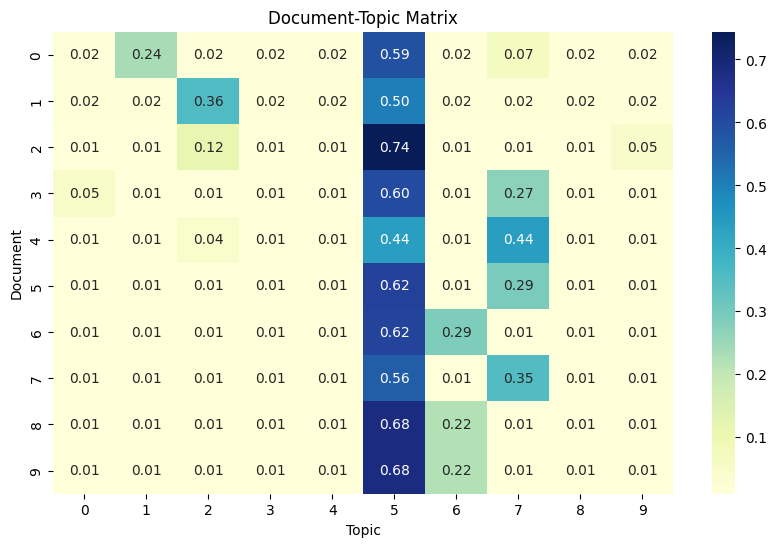

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Sample Document-Topic Matrix (replace with your actual matrix)

topic_result_subset = topic_result[:10]


# Create heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(topic_result_subset, cmap='YlGnBu', annot=True, fmt=".2f")
plt.xlabel('Topic')
plt.ylabel('Document')
plt.title('Document-Topic Matrix')
plt.show()

In [ ]:
old_values = [0,1, 2, 3,4,5,6,7,8,9]  # List of values to be replaced
new_values = ["Olahraga",
              "Kesehatan Publik",
              "Keamanan Publik1",
              "Keamanan Publik2",
              "Ekonomi Lokal",
              "Layanan Masyarakat",
              "Keamanan Publik3",
              "Politik",
              "Lingkungan",
              "Pendidikan"]  # List of corresponding replacement values

df['topics_name'] = df['Topic'].replace(old_values, new_values)

In [ ]:
df.head()


In [ ]:
text_test = df[["title","text","topics_name"]]
text_test

In [ ]:
text_test.to_excel('text_test2_edit3.xlsx')

In [ ]:
df.iloc[796]


target                                                       banggai
title                Aleg Banggai Ingatkan Kondisi Pasca Migas Habis
text               BANGGAI RAYA- Wakil rakyat Parlemen Teluk Lalo...
lwr                banggai raya- wakil rakyat parlemen teluk lalo...
clean_number       banggai raya- wakil rakyat parlemen teluk lalo...
clean_punct        banggai raya  wakil rakyat parlemen teluk lalo...
clean_double_ws    banggai raya wakil rakyat parlemen teluk lalon...
stemmed            bangga raya wakil rakyat parlemen teluk lalong...
filtered           bangga raya wakil rakyat parlemen teluk lalong...
tokenized          [bangga, raya, wakil, rakyat, parlemen, teluk,...
Topic                                                              4
topics_name               Local Governance and Community Development
Name: 796, dtype: object

In [ ]:
print(df['text'][127])

# Giving Title

In [ ]:
# Input
text_url = 'https://raw.githubusercontent.com/TaillessTanuki/Berita_Banggai/main/text_test2.csv'

# Read CSV file with 'latin-1' encoding
input_df = pd.read_csv(text_url, encoding='cp1252')

# Convert all columns to string
input_df = input_df.astype(str)

In [ ]:
input_df.head()

,text,topics_name
0,KABAR LUWUK – Suasana Pasar Murah bersubsidi ...,Layanan Publik
1,"KABAR LUWUK – Film Horor“Piara Mayat”,Kreati...",Layanan Publik
2,KABAR LUWUK –Festival Malabot Tumbe 2023Kemba...,Layanan Publik
3,“Kerja Cepat dan Terkoordinir dalam Penerbitan...,Layanan Publik
4,KABAR LUWUK –Bawaslu BanggaiPerkuat Koordinas...,Layanan Publik


In [ ]:
# parameter
stemmed_url= 'https://raw.githubusercontent.com/TaillessTanuki/Berita_Banggai/main/stemmed_words_tanpa_token_stopword.csv'

df = pd.read_csv(stemmed_url)

df = df.astype(str)

In [ ]:
df.head()

In [ ]:
# Assuming df1 is the DataFrame where you want to add the "title" column,
# and df2 is the DataFrame containing the "text" and "title" columns to match against

import pandas as pd

# Iterate through rows of df1
for index, row in input_df.iterrows():
    # Iterate through rows of df2
    for index2, row2 in df.iterrows():
        # Check if the "text" values match
        if row['text'] == row2['text']:
            # Assign the corresponding "title" value from df2 to df1
            input_df.at[index, 'title'] = row2['title']
            # Break the inner loop as we found a match
            break

# Display df1 with the added "title" column
print(input_df.head())

                                                text     topics_name  \
0  KABAR LUWUK –  Suasana Pasar Murah bersubsidi ...  Layanan Publik   
1  KABAR LUWUK  –  Film Horor“Piara Mayat”,Kreati...  Layanan Publik   
2  KABAR LUWUK  –Festival Malabot Tumbe 2023Kemba...  Layanan Publik   
3  “Kerja Cepat dan Terkoordinir dalam Penerbitan...  Layanan Publik   
4  KABAR LUWUK  –Bawaslu BanggaiPerkuat Koordinas...  Layanan Publik   

                                               title  
0  Mobil Sim Keliling Polres Banggai Meriahkan Pa...  
1  Film Horor “Piara Mayat”,  Kreativitas Anak Mu...  
2  Festival Malabot Tumbe 2023 Kembali Meriahkan ...  
3  Rakor Kampanye Damai Pemilu 2024, Polres Bangg...  
4  Bawaslu Banggai Perkuat Koordinasi dengan Panw...  


In [ ]:
input_df.head()

,text,topics_name,title
0,KABAR LUWUK – Suasana Pasar Murah bersubsidi ...,Layanan Publik,Mobil Sim Keliling Polres Banggai Meriahkan Pa...
1,"KABAR LUWUK – Film Horor“Piara Mayat”,Kreati...",Layanan Publik,"Film Horor “Piara Mayat”, Kreativitas Anak Mu..."
2,KABAR LUWUK –Festival Malabot Tumbe 2023Kemba...,Layanan Publik,Festival Malabot Tumbe 2023 Kembali Meriahkan ...
3,“Kerja Cepat dan Terkoordinir dalam Penerbitan...,Layanan Publik,"Rakor Kampanye Damai Pemilu 2024, Polres Bangg..."
4,KABAR LUWUK –Bawaslu BanggaiPerkuat Koordinas...,Layanan Publik,Bawaslu Banggai Perkuat Koordinasi dengan Panw...


In [ ]:
input_df.to_excel('text_test2_edit.xlsx')